# Faceted search with postgres using tsvectors

<b>TL;DR</b> Faceting adds a rich layer of interaction into underlying data, however when the data starts getting big,
using a distributed search engine such as Elasticsearch has become the way to go. In this post, we will discuss how
can you enable faceted-search using a lightweight single-instance postgres setup and its text-search-vector (tsvector) data type.

## What is faceted search?
The term faceted-search gained popularity with advent and evolution of powerful search frameworks such as [Apache's lucene](https://lucene.apache.org/). Lucene's documentation also includes a [well-explained document](http://lucene.apache.org/core/4_0_0/facet/org/apache/lucene/facet/doc-files/userguide.html) on different aspects of faceted-search.

In simple terms, __facet__ is a curated division of a dataset with an intent to study, explore or search items within it. And thus __faceted-search__ is a search operation facilitated via facets. From real-world examples, facets are created via categories (or subcategories) that you'd see in search results of an application (see Fig 1). With the help of facets, you can narrow down your search context to meet your interests.

<img src="img/facets-example.jpg" alt="drawing" width="400" />

Fig 1. shows an example of facets with respect to `Listing Type` of houses in [zillow](https://www.zillow.com/). The facets here are static in nature, that is, you'd always see the same list of categories even if you modify filters on bedroom-type or price-range. However, facet-counts do get updated and thus gives you an informational summary of the results you will see.

## Why discuss postgres for faceted-search?
Although there are sophisticated search-platforms such as Solr and Elasticsearch which make faceted-search quickly accessible to any application, a lot of typical web-applications rely on using a SQL-based relational database such as postgres because it is very lightweight to setup in production with requirements such as access-control, versioning schema-migrations and simple integration with a given front-end technology.  

However, the lightweight setup plays against postgres when it comes to supporting complex operations on large datasets such as ... _faceted-search_. Most postgres implementations do not have a distributed storage or a distributed query engine to make use of a multi-node setup. And with this, there's limited performance you could extract out of a postgres database. However, you can certainly do better than relying upon an optimized search index and group-by sql operations. We would show how to make faceting way more efficient by leveraging the functionality of postgresql's [text-search vectors](https://www.postgresql.org/docs/8.3/datatype-textsearch.html) (tsvectors).


## Problem Definition

The search aspect of _faceted-search_ is a plain-old filter operation, complex part is showing rich useful facets. And thus, our focus here would be in building rich dynamic facets which get updated each time user activates a facet.

Lets say we are working on a dataset of patient-health records where-in each record has certain metadata associated to it as a set of meta_field-value pairs. For example, `patient's state` is a meta_field and `California`, `Arizona`, etc. are its associated values.
For practical use-cases, it is fair to assume total number of unique meta_field-value pairs can be fairly diverse (~100K) but number of possible meta_fields is small (<100).

        record - [ set of (meta_field, value) pairs ]

Lets define `filter` operation on a record as below:

        filter - [ set of (meta_field, value) pairs expected in a record's metadata ]

A `facted-search` operation on this dataset would rely upon using meta_field as the source of facet (a category).
More concretely, we will define `faceted-search` operation as below:

#### faceted-search pseudo-code

    with filter = <user-defined filter>
    for each meta_field in dataset:
      find top-k most frequently occuring values wrt # of records
      s.t only records with metadata as per filter conditions are counted

The above operation does look a bit complex irrespective of what data model you choose because you are doing a filtered-aggregation operation over entire dataset for each meta-field.

### Traditional SQL solution

For considering a SQL solution, we have to define a data-model representation. Applications are usually constrained by their own schema requirements and a generic data-model mighn't work for all use cases. So without taking into account any application-specific schema constraints, for a best-case scenario, lets assume an efficient collapsed data model mapping each record to its metadata as below:

<div id='tab1' style='float:left'>
    <table>
      <tr>
        <th></th>
        <th>Data Type</th>
      </tr>
      <tr>
        <td><b>record_id</b></td>
        <td>UUID</td>
      </tr>
      <tr>
        <td><b>metadata</b></td>
        <td>jsonb</td>
      </tr>
    </table>
</div>

#####  Representative SQL-query for a meta-field `state`

For illustrative purposes, here's what a SQL query resolving the above pseudocode would look like:

    SELECT
     records.metadata -> 'state' AS meta_field,
     count(*) AS meta_field_count
    FROM
     records
    WHERE
     records.metadata @> '{"patient_ethnicity": "Caucasian", "provider_specialty_string": "Acute Care"}'::jsonb
    GROUP BY
     meta_field
    ORDER BY
     meta_field_count
    LIMIT
     50

Here, `facet` in action is `Caucasian` patients treated by `Acute Care` specialists. 

`@>` is an efficient [jsonb operator](https://www.postgresql.org/docs/9.6/functions-json.html#FUNCTIONS-JSONB-OP-TABLE) that can be indexed to check for containment of one jsonb record with respect to another.

You would repeat the above operation for all meta fields.

## Redefining problem using tsvectors

The complexity of above problem amounts to looking at the frequency of occurence of all qualified (meta_field, value) pairs. If we model each (meta_field, value) pair as a word instead, this becomes a word-count problem. And guess what, we don't have to implement a word-count function, its inbuilt ([ts_stat](https://www.postgresql.org/docs/9.6/functions-textsearch.html)) into postgres as it obliges itself as a text-search engine. 

Building onto this, a `record` becomes a set of words and thus can be represented as a text document. Group of records combined together is still a text document. And same applies to `filter` too, however, as we move towards a text-search problem, we can call `filter` as a text query on text document `record`. 

Thus, the problem can now be defined as:

    get word counts over all such `record` text-documents
       which match `filter` text-query

    process words from word-counts to get top-k values per meta-field

### Data model

To implement this approach, we need a model that looks like below:

<div id='tab2' style='float:left'>
    <table>
      <tr>
        <th></th>
        <th>Data Type</th>
      </tr>
      <tr>
        <td><b>record_id</b></td>
        <td>UUID</td>
      </tr>
      <tr>
        <td><b>record_tsv</b></td>
        <td>tsvector</td>
      </tr>
    </table>
</div>

<b>NOTE:</b> Even if you are bound by application schema constraints, you can build a [materialized view](https://www.postgresql.org/docs/9.6/rules-materializedviews.html) from your tables so that the data representation has above columns. 

#####  Representative SQL-query for all meta-fields combined

    select meta_field, value, ndoc as freq
    from
      (
        select
          split_part(word, ':', 1) as meta_field,
          split_part(word, ':', 2) as value,
          ndoc,
          row_number() OVER (
            partition by split_part(word, ':', 1)
            order by ndoc desc
          ) as rank
        from
          ts_stat(
            $$
            select
              record_tsv
            from
              records
              where record_tsv @> to_tsquery(
                  'provider_specialty_string:Multispecialty' & 
                  'patient_ethnicity:Caucasian')
            $$
          )
      ) meta_field_value_counts
    where
      rank <= 50;

The query does look a little bit complicated probably because `ts_stat` expects you to pass a list of `ts_vectors` to compute word counts upon and then there's extraction of field and value from the words on results of `ts_stat`.

Here, preprocessing is required to convert each record's metadata to a `tsvector`. You can see `to_tsquery` function call above as to how we formed a word `patient_ethnicity:Caucasian` using `("patient_ethnicity", "Caucasian")` as (meta_field, value) pair.

## Evaluation

Before we do performance measurements and comparisons, one thing to be noted is that query performance for all approaches depends on the coverage of selected facet (`filters`). That is, query performance for a facet that covers just 0.1% of dataset will be vastly better than a facet that covers 50% of the same dataset. 

### Comparison with traditional-sql approach

Starting with that note, lets see how tsvectors approach compares with tradition-sql approach used above on a 100K dataset with 15 meta-fields on each record.

In [15]:
%matplotlib inline

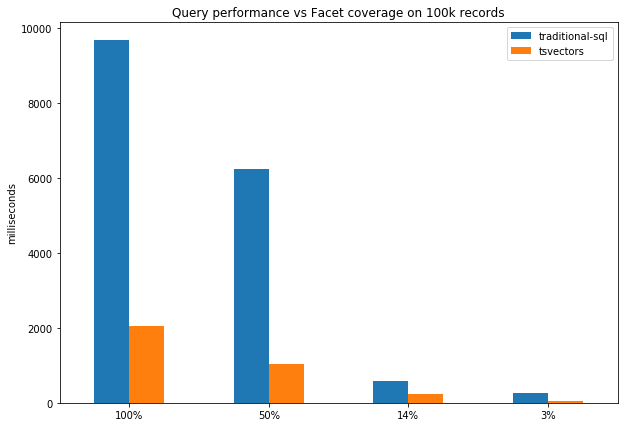

In [40]:
import pandas as pd
tsv_times = [2053, 1038, 246, 53]
sql_times = [644*15, 415*15, 38*15, 17*15]
index = ['100%', '50%', '14%', '3%']
df = pd.DataFrame({'tsvectors': tsv_times, 'traditional-sql': sql_times}, index=index)
ax = df.plot.bar(rot=0, figsize=(10, 7))
ax.set_ylabel('milliseconds')
_ = ax.set_title('Query performance vs Facet coverage on 100k records')

As coverage of facet increases, `tsvectors` approach edges out significantly against traditional-sql approach. Facet coverage here is indicative of the number of records that are worked on by the group-by operation in tradtional-sql appraoch and `ts_stat` operation in tsvector approach. Clearly, `ts_stat` owns the battle.

### Comparison with Elasticsearch

Given that tsvectors obtains significant performance gains over traditional-sql approach, the question that remains to be answered is - can it replace a distributed lucene-powered search engine such as Elasticsearch.

Lets see how performance of tsvectors approach on a single instance postgres database compares with a 3-node Elasticsearch cluster. Also, lets bump the stakes as well and use a dataset sized with 1 million records and ~80 field-value pairs per record on average.

Here are the numbers:

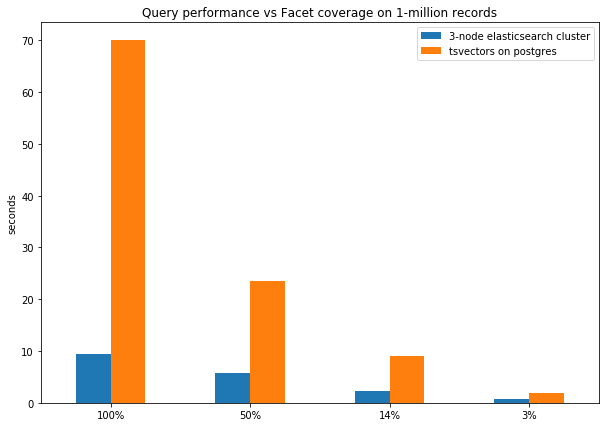

In [46]:
tsv_times = [70, 23.6, 9.0, 1.8]
es_times = [9.5, 5.69, 2.23, 0.725]
index = ['100%', '50%', '14%', '3%']
df = pd.DataFrame({'tsvectors on postgres': tsv_times, '3-node elasticsearch cluster': es_times}, index=index)
ax = df.plot.bar(rot=0, figsize=(10, 7))
ax.set_ylabel('seconds')
_ = ax.set_title('Query performance vs Facet coverage on 1-million records')

Usually web-applications have a response timeout when a query takes more than a minute. When working with operations mounting to tens of millions of records, postgres does disappoint you. Elasticsearch however can be scaled with as many number of nodes you would want (in theory) and can thus overcome performance limitations with huge datasets.

## Conclusion

Postgresql's text-search features prove to be immensely efficient as compared to group-by operations which makes `tsvectors` approach stand out and can provide substantial performance gains on datasets with upto hundreds of thousands of records. 

This can be greatly helpful if you want to just try out faceted-search in your postgres-powered web-application without having to stand up new infrastructure. However, if the scale of datasets you employ under this feature extend in the order of millions, it's time to make a move.
